# Damped Oscillator Simulation

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

np.random.seed(42)

## Parameters and Simulation function

In [23]:
# Physical parameters
m = 1.0     # mass
k = 20.0    # stiffness
c = 1.5     # damping

# Simulation settings
dt = 0.001
T = 30.0 # 30 seconds is good for project purpose
N = int(T / dt)
t = np.linspace(0, T, N)

# External force: small oscillatory + noise
F = 0.5 * np.sin(2 * np.pi * 0.8 * t) + 0.05 * np.random.randn(N)

In [24]:
def simulate_damped_oscillator(m, c, k, F, dt):
    N = len(F)
    x = np.zeros(N)
    v = np.zeros(N)
    a = np.zeros(N)

    for i in range(N-1):
        a[i] = (F[i] - c * v[i] - k * x[i]) / m
        v[i+1] = v[i] + a[i] * dt
        x[i+1] = x[i] + v[i] * dt
    
    a[-1] = (F[-1] - c * v[-1] - k * x[-1]) / m
    return x, v, a

In [25]:
x, v, a = simulate_damped_oscillator(m, c, k, F, dt)

In [26]:
# Gaussian noise

noise_level = 0.01
x_noisy = x + noise_level * np.random.randn(N)
v_noisy = v + noise_level * np.random.randn(N)
a_noisy = a + noise_level * np.random.randn(N)

## Anomalies

In [27]:
def inject_spike(x, idx, magnitude=4.0):
    x[idx] += magnitude * np.std(x)
    return x

def inject_noise_burst(x, start, duration=50, scale=2.0):
    end = min(start + duration, len(x))
    x[start:end] += scale * np.random.randn(end - start)
    return x

def inject_drift(x, start, slope=0.0002): # instead of 0.005, makes anomaly detection less trivial because now x explodes 
    drift = slope * np.arange(len(x) - start)
    x[start:] += drift
    return x

In [28]:
labels = np.zeros(N)

x_anom = x_noisy.copy()

# Spike
idx_spike = np.random.randint(1000, N-1000)
x_anom = inject_spike(x_anom, idx_spike)
labels[idx_spike] = 1

# Noise burst
burst_duration = 50
start_burst = np.random.randint(1000, N - 1500)
end_burst = start_burst + burst_duration
x_anom = inject_noise_burst(x_anom, start=start_burst, duration=burst_duration)
labels[start_burst:end_burst] = 1

# Drift
start_drift = np.random.randint(2000, N-2000)
drift_duration = 1500
end_drift = min(start_drift+drift_duration, N)

x_anom[start_drift:end_drift] = inject_drift(
    x_anom.copy(), start=start_drift
)[start_drift:end_drift]

labels[start_drift:end_drift] = 1

## Plots

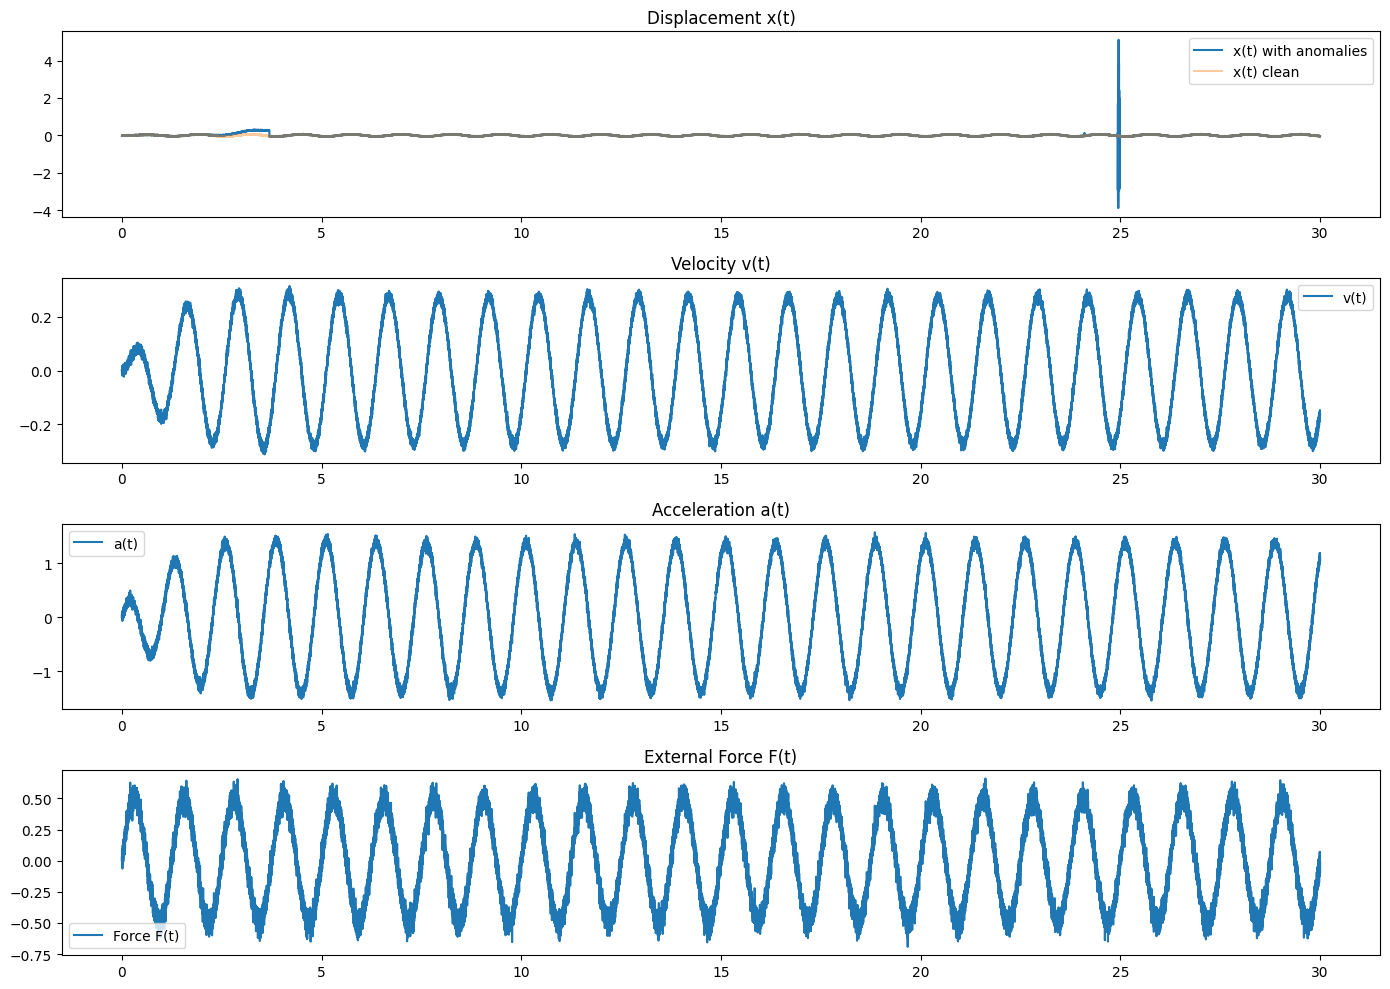

In [29]:
plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(t, x_anom, label="x(t) with anomalies")
plt.plot(t, x_noisy, alpha=0.4, label="x(t) clean")
plt.legend()
plt.title("Displacement x(t)")

plt.subplot(4, 1, 2)
plt.plot(t, v_noisy, label="v(t)")
plt.legend()
plt.title("Velocity v(t)")

plt.subplot(4, 1, 3)
plt.plot(t, a_noisy, label="a(t)")
plt.legend()
plt.title("Acceleration a(t)")

plt.subplot(4, 1, 4)
plt.plot(t, F, label="Force F(t)")
plt.legend()
plt.title("External Force F(t)")

plt.tight_layout()
plt.show()

## Create dataset

In [30]:
df = pd.DataFrame({
    "t": t,
    "x": x_anom,
    "x_clean": x_noisy,
    "v": v_noisy,
    "a": a_noisy,
    "F": F,
    "label": labels.astype(int)
})
df.head()

output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)

df.to_csv(os.path.join(output_dir, "simulation.csv"), index=False)

print("Dataset saved to ../data/imulation.csv")

Dataset saved to ../data/imulation.csv
